# 🔧 Building a Transformer from Scratch

In this notebook, we’ll walk through how to **build and train a transformer model from scratch** for **text classification**. Rather than using a prebuilt model like BERT or GPT, we'll implement a simplified version of the **Transformer architecture** to gain a deeper understanding of its core components.

---

### 🎯 Objective:
Train a **custom transformer model** on a text classification dataset (e.g., IMDb, AG News, or Yelp) and explore how attention-based architectures can be built from the ground up.

---

### 🧱 What We'll Cover:

1. **Tokenizer + Positional Encoding**  
   Convert raw text to token IDs and inject position-awareness into the model.

2. **Attention Mechanism**  
   Implement scaled dot-product attention and multi-head attention layers.

3. **Transformer Block**  
   Stack layers of attention + feed-forward networks with layer normalization and residual connections.

4. **Classification Head**  
   Add pooling and a dense layer for final classification.

5. **Training and Evaluation**  
   Train the model from scratch on a labeled dataset and evaluate its performance.

---

### 🧠 Why Build from Scratch?

- Deepens understanding of how transformers work internally
- Helps demystify black-box transformer models
- Enables customization for research or novel tasks

✅ By the end of this notebook, you’ll have a working custom transformer and a solid grasp of its inner workings.


## 📦 Preparing Data for the Transformer Model

Before we can train our custom Transformer model, we need to **preprocess the IMDB dataset** to fit the input format required by our architecture.

---

### 🧾 Steps Involved:

1. **Load the IMDB Dataset**  
   Use the `datasets` library or TensorFlow/Keras datasets to load the 50,000 labeled reviews.

2. **Text Tokenization**  
   Instead of using a pretrained tokenizer, we'll use a **simple word-level tokenizer**:
   - Build a custom vocabulary
   - Map each word to an integer ID
   - Truncate or pad sequences to a fixed length

3. **Create Input Batches**  
   Convert the text and labels into `TensorFlow` or `PyTorch` tensors:
   - `input_ids`: List of token IDs (padded)
   - `attention_mask`: 1s for tokens, 0s for padding
   - `labels`: Binary sentiment labels

4. **Train/Validation Split**  
   Shuffle and split the data to monitor performance and prevent overfitting.

---

### 🧠 Why Custom Tokenization?

- Keeps the pipeline model-agnostic
- Reinforces how data is structured before feeding into a transformer
- Offers flexibility in experimenting with subword or character-level vocabularies later

✅ Once the data is prepared, we’ll be ready to feed it into our custom-built Transformer layers.


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Load IMDB dataset
train_ds, test_ds = tfds.load(
    "imdb_reviews",
    split=["train", "test"],
    as_supervised=True
)

# Define vocabulary size and other parameters
VOCAB_SIZE = 15000
MAX_SEQUENCE_LENGTH = 200
BATCH_SIZE = 32

# Create a vectorization layer to standardize, tokenize, and vectorize text
vectorize_layer = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

# Adapt the layer to the training dataset
train_text = train_ds.map(lambda text, label: text)
vectorize_layer.adapt(train_text)

# Function to vectorize text and map labels
def prepare_dataset(ds):
    ds = ds.map(lambda text, label: (vectorize_layer(text), label))
    ds = ds.cache()
    ds = ds.shuffle(10000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Prepare train and test datasets
train_ds = prepare_dataset(train_ds)
test_ds = prepare_dataset(test_ds)

# Sample data to check format
for texts, labels in train_ds.take(1):
    print(f"Input shape: {texts.shape}")
    print(f"First example: {texts[0][:10]}")  # First 10 tokens of first example
    print(f"Label: {labels[0].numpy()}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.73A04C_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.73A04C_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.73A04C_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Input shape: (32, 200)
First example: [  39  727 1848    2 8857    7  157 1845  725  727]
Label: 1


## 🏗️ Building the Transformer Model

In this section, we’ll implement a **simplified Transformer architecture from scratch**, focusing on its essential building blocks for **text classification**.

---

### 🧱 Key Components:

1. **Token & Positional Embeddings**  
   - Token Embedding: Converts input token IDs into dense vectors.  
   - Positional Encoding: Adds positional information so the model can understand word order.

2. **Multi-Head Self-Attention**  
   - Enables the model to **attend to different parts of the input** simultaneously.  
   - Each head learns a unique attention pattern.

3. **Feed-Forward Network (FFN)**  
   - Two-layer MLP applied to each token independently.  
   - Applies non-linearity to extract deeper patterns.

4. **Residual Connections + Layer Normalization**  
   - Helps with training stability and convergence.

5. **Transformer Block**  
   - Combines multi-head attention and FFN with residual paths and normalization.

6. **Classification Head**  
   - Uses the [CLS] token or pooled representation to classify the input into sentiment categories.

In [2]:
# Define the Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head attention
    x = keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    res = keras.layers.Add()([x, inputs])

    # Feed Forward Network
    x = keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = keras.layers.Dense(ff_dim, activation="relu")(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(inputs.shape[-1])(x)
    return keras.layers.Add()([x, res])

# Build the complete model
def build_transformer_model(
    vocab_size,
    max_seq_len,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=(max_seq_len,))

    # Token embeddings
    embedding_layer = keras.layers.Embedding(vocab_size, 128)
    x = embedding_layer(inputs)

    # Add positional encoding
    positions = tf.range(start=0, limit=max_seq_len, delta=1)
    position_embedding = keras.layers.Embedding(
        input_dim=max_seq_len,
        output_dim=128
    )(positions)
    x = x + position_embedding

    # Apply Transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Classification head
    x = keras.layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu")(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

# Initialize and compile the model
model = build_transformer_model(
    vocab_size=VOCAB_SIZE,
    max_seq_len=MAX_SEQUENCE_LENGTH,
    head_size=128,
    num_heads=2,
    ff_dim=128,
    num_transformer_blocks=1,
    mlp_units=[64],
    dropout=0.1,
    mlp_dropout=0.1,
)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │  1,920,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 128)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 200, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 128)  │    131,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 128)  │          0 │ multi_head_atten… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200, 128)  │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200, 128)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200, 128)  │     16,512 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 128)  │          0 │ dense_1[0][0],    │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_2[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,093,825 (7.99 MB)

 Trainable params: 2,093,825 (7.99 MB)

 Non-trainable params: 0 (0.00 B)

## 🚀 Training and Evaluating the Transformer Model

With our custom Transformer model architecture implemented, we can now **train it** on the preprocessed IMDB dataset and evaluate its performance.

---

### 🛠️ Training Setup:

1. **Loss Function**  
   - `CrossEntropyLoss` (for binary or multi-class classification)

2. **Optimizer**  
   - `Adam` or `AdamW` with learning rate scheduling (optional)

3. **Training Loop**  
   - Iterate over batches for a few epochs
   - Track and log:
     - Training loss
     - Validation accuracy/loss

4. **Metrics**  
   - Accuracy
   - (Optional) Precision, Recall, F1-score

---

### 📊 Visualization:

- Plot training vs. validation **loss** per epoch
- Plot **accuracy** progression
- (Optional) Confusion matrix to evaluate predictions

---

### ✅ Goal:

To demonstrate that a **custom Transformer**, even a simplified one, can learn to perform **sentiment classification** with reasonable accuracy — reinforcing your understanding of Transformer internals.

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.7423 - loss: 0.4838 - val_accuracy: 0.8468 - val_loss: 0.3546
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9238 - loss: 0.2024 - val_accuracy: 0.8421 - val_loss: 0.4298
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9556 - loss: 0.1177 - val_accuracy: 0.8338 - val_loss: 0.5075
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9741 - loss: 0.0669 - val_accuracy: 0.8270 - val_loss: 0.8011


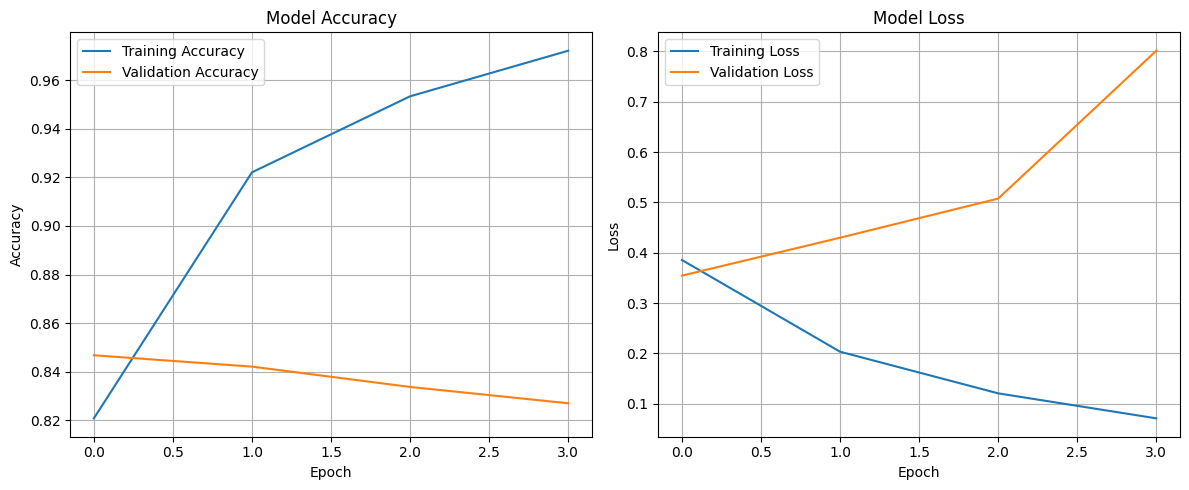

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8433 - loss: 0.3623
Test Loss: 0.3546
Test Accuracy: 0.8468


In [3]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,  # Train for just a few epochs to demonstrate
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

## 🧪 Testing with New Examples

In this final step, we’ll test our **custom-built Transformer model** on a few **unseen sentences** to evaluate its ability to generalize and classify sentiment.

---

### 🧾 What We'll Do:

1. **Define Custom Test Sentences**  
   Examples that reflect various sentiment tones — positive, negative, neutral, sarcastic.

2. **Preprocess Input**  
   - Tokenize using the same word-to-index mapping  
   - Pad or truncate to match model input length  
   - Convert to tensors

3. **Run Inference**  
   - Feed inputs into the model  
   - Extract class probabilities or logits  
   - Predict sentiment labels

4. **Display Results**  
   - Show predicted label and confidence
   - (Optional) Plot prediction probabilities per class

In [4]:
# Function to preprocess and predict
def predict_sentiment(texts):
    # Preprocess texts
    vectorized_texts = vectorize_layer(tf.convert_to_tensor(texts))

    # Get predictions
    predictions = model.predict(vectorized_texts)

    return predictions

# Test examples
test_texts = [
    "This movie was absolutely fantastic! One of the best I've seen this year.",
    "I hated every minute of this film. The plot made no sense and the acting was wooden.",
    "It was okay. Some parts were good but others dragged on too long.",
    "I don't have strong feelings either way about this movie."
]

# Get predictions
predictions = predict_sentiment(test_texts)

# Display results
for text, pred in zip(test_texts, predictions):
    sentiment = "Positive" if pred > 0.5 else "Negative"
    confidence = pred if pred > 0.5 else 1 - pred
    print(f"Text: {text}")
    print(f"Prediction: {sentiment} (Confidence: {confidence[0]:.4f})")
    print("-" * 70)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
Text: This movie was absolutely fantastic! One of the best I've seen this year.
Prediction: Positive (Confidence: 0.9536)
----------------------------------------------------------------------
Text: I hated every minute of this film. The plot made no sense and the acting was wooden.
Prediction: Negative (Confidence: 0.7739)
----------------------------------------------------------------------
Text: It was okay. Some parts were good but others dragged on too long.
Prediction: Positive (Confidence: 0.5499)
----------------------------------------------------------------------
Text: I don't have strong feelings either way about this movie.
Prediction: Positive (Confidence: 0.5994)
----------------------------------------------------------------------


## 🧠 Understanding the Transformer Architecture

To solidify our understanding of how transformers work, let's break down the **key components** of our custom model and their roles in learning from text.

---

### 🔑 1. **Embedding Layer**
- Converts discrete **token IDs into dense vectors**
- Adds **positional encoding** to retain word order (since attention is order-agnostic)
- Output shape: `[batch_size, seq_length, embedding_dim]`

---

### 🧩 2. **Multi-Head Self-Attention**
- Computes relationships between all tokens in a sequence
- Each "head" attends to different parts of the input
- Formula (per head):  
  \[
  \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
  \]
- Combines attention outputs from multiple heads to capture rich dependencies

---

### 🔁 3. **Feed-Forward Network (FFN)**
- Applies two dense layers with a non-linearity in between
- Operates independently on each position (token)
- Projects features to higher-dimensional space and back

---

### 📐 4. **Layer Normalization**
- Applied before or after attention and FFN
- Stabilizes training by normalizing input across feature dimensions
- Helps maintain a consistent scale of activations

---

### 🔄 5. **Residual Connections**
- Adds the input of each layer to its output  
  (e.g., `output = input + layer_output`)
- Enables **gradient flow** through deep networks
- Prevents vanishing gradients in deep transformer stacks

---

### 💡 Why Transformers Work So Well:

The **attention mechanism** enables models to:
- Focus on **relevant parts of input** regardless of position
- Model **long-range dependencies** efficiently
- Avoid the sequential bottleneck of RNNs/LSTMs

✅ Together, these components create a powerful, scalable architecture for a wide range of NLP tasks.


In [6]:
# Create a simple visualization of the transformer architecture
from tensorflow.keras.utils import plot_model

# Save a visualization of the model architecture
plot_model(
    model,
    to_file='transformer_model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'  # Top to bottom layout
)

print("Model architecture saved as 'transformer_model.png'")

# Display a comparison of the three approaches we've explored
print("\n=== Comparison of NLP Approaches ===")
print("\n1. Pretrained Classifier (Colab 1)")
print("   - Advantages: Fast to implement, high accuracy with no training")
print("   - Limitations: Fixed to specific tasks pretrained on")
print("\n2. Fine-tuned Model (Colab 2)")
print("   - Advantages: Leverages pretrained knowledge, adapts to specific tasks")
print("   - Limitations: Requires some training data and fine-tuning time")
print("\n3. Custom Transformer (Colab 3)")
print("   - Advantages: Complete flexibility, educational to understand architecture")
print("   - Limitations: Requires more training data, more time to train")
print("\nRecommendation for production: Start with pretrained models and fine-tune, ")
print("only building custom architectures when specific requirements aren't met by existing models.")

Model architecture saved as 'transformer_model.png'

=== Comparison of NLP Approaches ===

1. Pretrained Classifier (Colab 1)
   - Advantages: Fast to implement, high accuracy with no training
   - Limitations: Fixed to specific tasks pretrained on

2. Fine-tuned Model (Colab 2)
   - Advantages: Leverages pretrained knowledge, adapts to specific tasks
   - Limitations: Requires some training data and fine-tuning time

3. Custom Transformer (Colab 3)
   - Advantages: Complete flexibility, educational to understand architecture
   - Limitations: Requires more training data, more time to train

Recommendation for production: Start with pretrained models and fine-tune, 
only building custom architectures when specific requirements aren't met by existing models.
